## Wstępna ocena przydatności danych


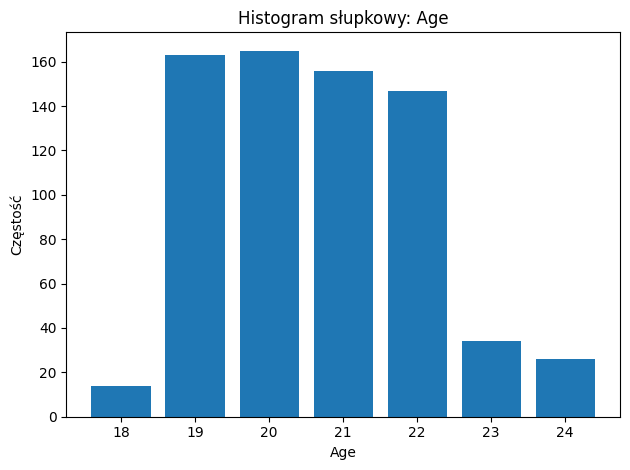

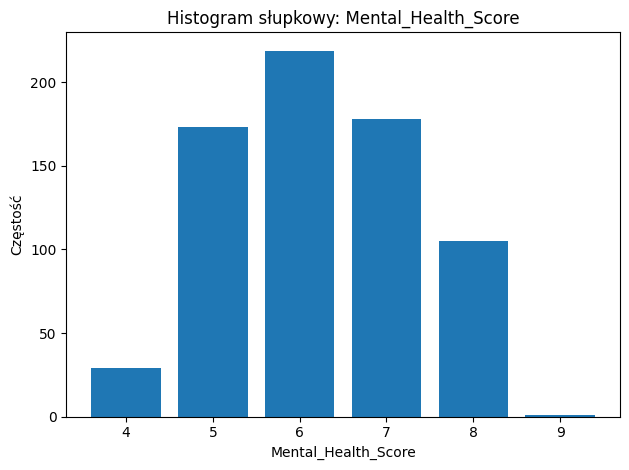

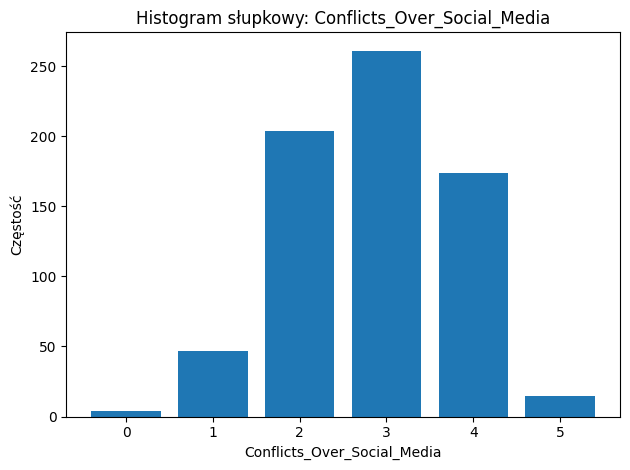

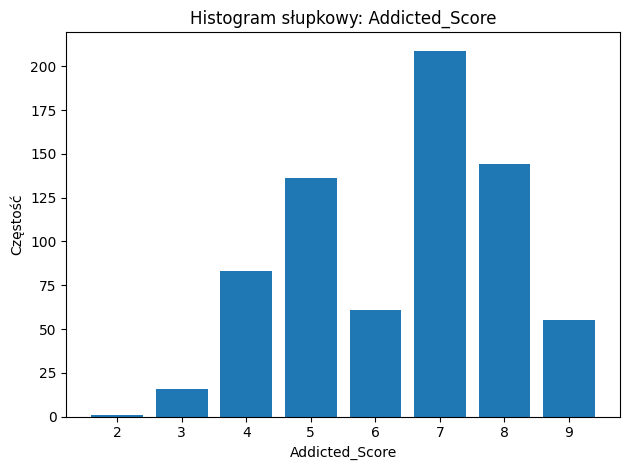

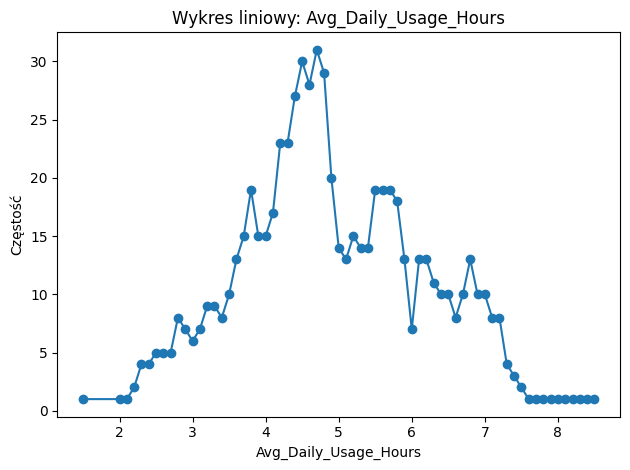

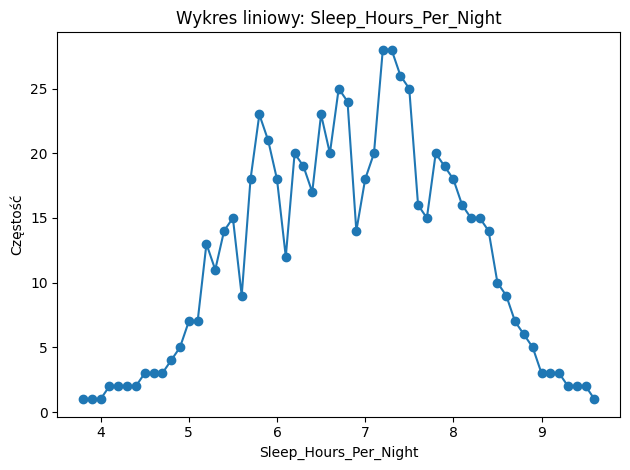

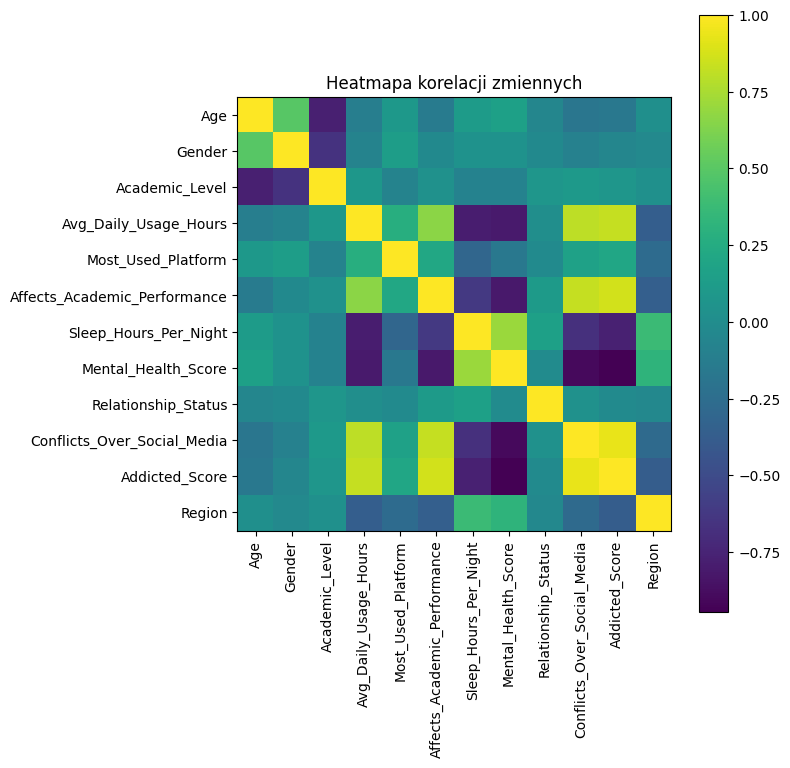

In [25]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import country_converter as coco
import pandas as pd

df = pd.read_csv("dataset/Students Social Media Addiction.csv")

bar_cols = [
    col for col in df.select_dtypes(include="number").columns
    if col not in ["Student_ID", "Avg_Daily_Usage_Hours", "Sleep_Hours_Per_Night"]
]

# rysowanie histogramów słupkowych
for col in bar_cols:
    counts = df[col].value_counts().sort_index()
    plt.figure()
    plt.bar(counts.index, counts.values)
    plt.xlabel(col)
    plt.ylabel("Częstość")
    plt.title(f"Histogram słupkowy: {col}")
    plt.tight_layout()
    plt.show()

# kolumny do wykresów liniowych
line_cols = ["Avg_Daily_Usage_Hours", "Sleep_Hours_Per_Night"]

# rysowanie wykresów liniowych
for col in line_cols:
    counts = df[col].value_counts().sort_index()
    plt.figure()
    plt.plot(counts.index, counts.values)
    plt.scatter(counts.index, counts.values)  # punkty dla czytelności
    plt.xlabel(col)
    plt.ylabel("Częstość")
    plt.title(f"Wykres liniowy: {col}")
    plt.tight_layout()
    plt.show()

df = pd.read_csv("dataset/Students Social Media Addiction.csv")

# Tworzenie z krajów kolumnę region
if "Country" in df.columns:
    override = {"UAE": "United Arab Emirates"}
    df["Country"] = df["Country"].replace(override)
    df["Region"] = coco.convert(names=df["Country"], to="continent")

#usuwanie niepotrzebnych kolumn
cols_to_drop = ["Country", "Student_ID"]
for col in cols_to_drop:
    if col in df.columns:
        df.drop(columns=col, inplace=True)
cols = ["Gender",
        "Affects_Academic_Performance",
        "Academic_Level",
        "Most_Used_Platform",
        "Relationship_Status",
        "Region"]
#zmiana wartości kategorycznych na numeryczne
for col in cols:
    le = LabelEncoder()
    le.fit(df[col])

le = LabelEncoder()
for col in ["Gender", "Affects_Academic_Performance", "Academic_Level", "Most_Used_Platform", "Relationship_Status", "Region"]:
    df[col] = le.fit_transform(df[col])

#macierz korelacji
corr = df.corr()

# Heatmapa
plt.figure(figsize=(8, 8))
plt.imshow(corr, aspect='equal')
plt.colorbar()
# opisy osi
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Heatmapa korelacji zmiennych")
plt.tight_layout()
plt.show()


## Przygotowanie Danych

- usuwanie kolumny Student_id
- stworzenie nowej kolumny z coutry na Region z powodu małej liczby powtórzeń krajów
- zmiana wartości kategorycznych na numeryczne (Encoder + OneHotEncoding)
- usuwanie przypadków odstających w godzinach używania social media i godzinach snu (jeśli takie istnieją)

In [26]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import country_converter as coco
from IPython.display import display, Markdown

# 1. Wczytanie danych
df = pd.read_csv("dataset/Students Social Media Addiction.csv")

# 2. Zamiana Country -> Region
if "Country" in df.columns:
    override = {"UAE": "United Arab Emirates"}
    df["Country"] = df["Country"].replace(override)
    df["Region"] = coco.convert(names=df["Country"], to="continent")

# 3. Usuwamy zbędne
for col in ["Country", "Student_ID"]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# 4. Label Encoding
label_cols = [
    "Gender",
    "Affects_Academic_Performance"
]
label_maps = {}
for col in label_cols:
    le = LabelEncoder().fit(df[col])
    df[col] = le.transform(df[col])
    label_maps[col] = pd.DataFrame({
        "Category": le.classes_,
        "Code": range(len(le.classes_))
    })
    display(Markdown(f"### Label mapping dla `{col}`"))
    display(label_maps[col])

# 5. One-Hot Encoding
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_ohe = ohe.fit_transform(df[["Most_Used_Platform", "Region", "Academic_Level", "Relationship_Status"]])
new_cols = ohe.get_feature_names_out(["Most_Used_Platform", "Region", "Academic_Level", "Relationship_Status"])
df_ohe = pd.DataFrame(X_ohe, columns=new_cols, index=df.index)

# budujemy mapowania per oryginalna kolumna
onehot_maps = {}
cats = ohe.categories_  # lista list: [platforms…, regions…]
for orig_col, cat_list in zip(["Most_Used_Platform", "Region", "Academic_Level", "Relationship_Status"], cats):
    prefix = orig_col + "_"
    feats = [c for c in new_cols if c.startswith(prefix)]
    onehot_maps[orig_col] = pd.DataFrame({
        "Category": cat_list,
        "OneHotColumn": feats
    })
    # wyświetl
    display(Markdown(f"### One-hot mapping dla `{orig_col}`"))
    display(onehot_maps[orig_col])

# 6. Ściągamy stare kolumny i dodajemy nowe wektory
df = pd.concat([df.drop(columns=["Most_Used_Platform", "Region", "Academic_Level", "Relationship_Status"]), df_ohe],
               axis=1)

# 7. Analiza outlierów (IQR) – bez zmian
cols = ["Avg_Daily_Usage_Hours", "Sleep_Hours_Per_Night"]
iqr_bounds = {}
for col in cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    iqr_bounds[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

mask = pd.Series(True, index=df.index)
for col, (low, high) in iqr_bounds.items():
    mask &= df[col].between(low, high)

outliers_iqr = df[~mask]
print("Outliery wg IQR dla Avg_Daily_Usage_Hours i Sleep_Hours_Per_Night:" + '\n')
print(outliers_iqr[cols])

### Label mapping dla `Gender`

,Category,Code
0,Female,0
1,Male,1


### Label mapping dla `Affects_Academic_Performance`

,Category,Code
0,No,0
1,Yes,1


### One-hot mapping dla `Most_Used_Platform`

,Category,OneHotColumn
0,Facebook,Most_Used_Platform_Facebook
1,Instagram,Most_Used_Platform_Instagram
2,KakaoTalk,Most_Used_Platform_KakaoTalk
3,LINE,Most_Used_Platform_LINE
4,LinkedIn,Most_Used_Platform_LinkedIn
5,Snapchat,Most_Used_Platform_Snapchat
6,TikTok,Most_Used_Platform_TikTok
7,Twitter,Most_Used_Platform_Twitter
8,VKontakte,Most_Used_Platform_VKontakte
9,WeChat,Most_Used_Platform_WeChat


### One-hot mapping dla `Region`

,Category,OneHotColumn
0,Africa,Region_Africa
1,America,Region_America
2,Asia,Region_Asia
3,Europe,Region_Europe
4,Oceania,Region_Oceania


### One-hot mapping dla `Academic_Level`

,Category,OneHotColumn
0,Graduate,Academic_Level_Graduate
1,High School,Academic_Level_High School
2,Undergraduate,Academic_Level_Undergraduate


### One-hot mapping dla `Relationship_Status`

,Category,OneHotColumn
0,Complicated,Relationship_Status_Complicated
1,In Relationship,Relationship_Status_In Relationship
2,Single,Relationship_Status_Single


Outliery wg IQR dla Avg_Daily_Usage_Hours i Sleep_Hours_Per_Night:

     Avg_Daily_Usage_Hours  Sleep_Hours_Per_Night
6                      1.5                    8.0
486                    8.4                    3.9
496                    8.5                    3.8


## Korelacja Zmiennych



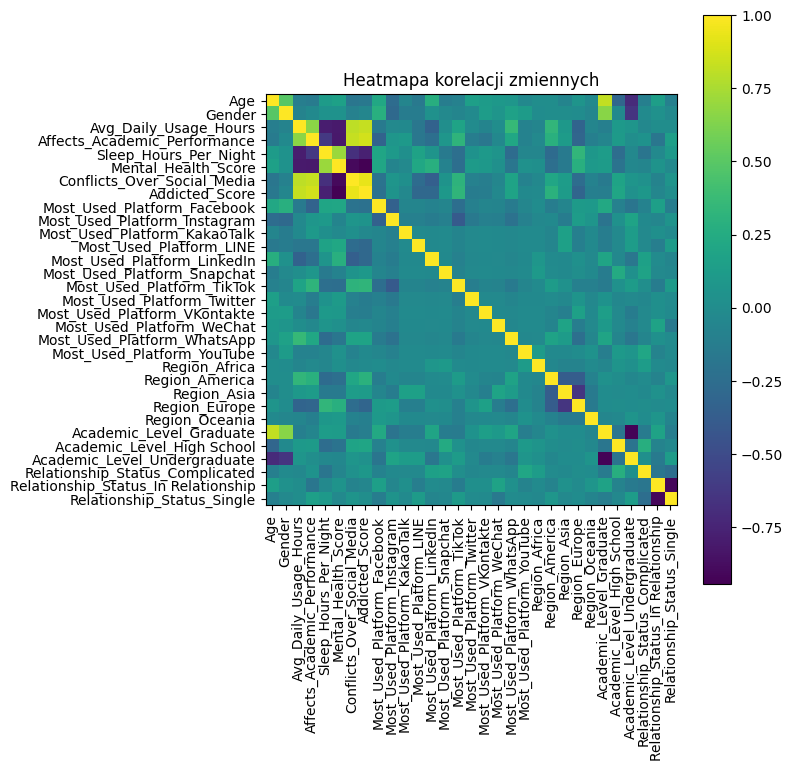

Conflicts_Over_Social_Media            0.933586
Affects_Academic_Performance           0.866049
Avg_Daily_Usage_Hours                  0.832000
Most_Used_Platform_TikTok              0.330558
Region_America                         0.297544
Academic_Level_High School             0.201333
Most_Used_Platform_WhatsApp            0.186327
Region_Asia                            0.119873
Most_Used_Platform_Snapchat            0.088549
Relationship_Status_Complicated        0.081717
Most_Used_Platform_Instagram           0.054669
Academic_Level_Undergraduate           0.035382
Relationship_Status_Single             0.014795
Region_Africa                         -0.015784
Most_Used_Platform_YouTube            -0.025478
Most_Used_Platform_WeChat             -0.034416
Most_Used_Platform_KakaoTalk          -0.036247
Relationship_Status_In Relationship   -0.049566
Gender                                -0.049692
Region_Oceania                        -0.106016
Academic_Level_Graduate               -0

In [27]:
import matplotlib.pyplot as plt

#macierz korelacji
corr = df.corr()

# Heatmapa
plt.figure(figsize=(8, 8))
plt.imshow(corr, aspect='equal')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Heatmapa korelacji zmiennych")
plt.tight_layout()
plt.show()

# Print dla korelacji addicted_score
corr_with_target = (
    corr["Addicted_Score"]
    .drop("Addicted_Score")
    .sort_values(ascending=False)
)

print(corr_with_target)

## Modelowanie

In [28]:
import pandas as pd
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_absolute_error, median_absolute_error, explained_variance_score, max_error
from IPython.display import display

# przygotowanie danych
X = df.drop(columns=["Addicted_Score"])
y = df["Addicted_Score"]

# przygotowanie CV
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# definiujemy miary
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
medae_scorer = make_scorer(median_absolute_error, greater_is_better=False)
evs_scorer = make_scorer(explained_variance_score)
maxe_scorer = make_scorer(max_error, greater_is_better=False)

# słownik modeli
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel="rbf", C=1.0, epsilon=0.1)
}

# słownik metryk
scoring = {
    "R2": "r2",
    "RMSE": rmse_scorer,
    "MAE": mae_scorer,
    "MedAE": medae_scorer,
    "EVS": evs_scorer,
    "MaxErr": maxe_scorer
}

# zbieramy wyniki
all_results = {}
for name, model in models.items():
    res = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    metrics = {}
    for metric in scoring:
        arr = res[f"test_{metric}"]
        if metric in ("RMSE", "MAE", "MedAE", "MaxErr"):
            arr = -arr
        metrics[f"{metric}_mean"] = arr.mean()
        metrics[f"{metric}_std"] = arr.std()
    all_results[name] = metrics

# konwersja do DataFrame z wierszami=modelami, kolumnami=metrykami
results_df = pd.DataFrame.from_dict(all_results, orient="index")

sorted_df = results_df.sort_values(by="R2_mean", ascending=False)
styled = sorted_df.style.format("{:.3f}").background_gradient(cmap="viridis")
display(styled)

#bez *std
mean_only_df = sorted_df.loc[:, [c for c in sorted_df.columns if not c.endswith("_std")]]
styled_mean_only = mean_only_df.style.format("{:.3f}").background_gradient(cmap="viridis")
display(styled_mean_only)


,R2_mean,R2_std,RMSE_mean,RMSE_std,MAE_mean,MAE_std,MedAE_mean,MedAE_std,EVS_mean,EVS_std,MaxErr_mean,MaxErr_std
RandomForest,0.985,0.006,0.188,0.047,0.069,0.018,0.000,0.000,0.986,0.006,0.910,0.179
GradientBoosting,0.980,0.005,0.223,0.038,0.124,0.018,0.057,0.004,0.980,0.005,0.964,0.149
LinearRegression,0.968,0.008,0.282,0.041,0.212,0.020,0.172,0.017,0.968,0.008,0.980,0.187
Ridge,0.968,0.008,0.282,0.040,0.211,0.019,0.171,0.017,0.968,0.008,0.973,0.178
SVR,0.951,0.008,0.348,0.035,0.261,0.025,0.188,0.014,0.952,0.008,1.109,0.152
Lasso,0.939,0.008,0.391,0.032,0.320,0.021,0.275,0.018,0.940,0.008,1.183,0.288


,R2_mean,RMSE_mean,MAE_mean,MedAE_mean,EVS_mean,MaxErr_mean
RandomForest,0.985,0.188,0.069,0.000,0.986,0.910
GradientBoosting,0.980,0.223,0.124,0.057,0.980,0.964
LinearRegression,0.968,0.282,0.212,0.172,0.968,0.980
Ridge,0.968,0.282,0.211,0.171,0.968,0.973
SVR,0.951,0.348,0.261,0.188,0.952,1.109
Lasso,0.939,0.391,0.320,0.275,0.940,1.183


## Tuning najlepszego modelu

=== Baseline (domyślny RF) ===
Baseline R2:    0.9842736873844175
Baseline RMSE:  0.19837281328258013


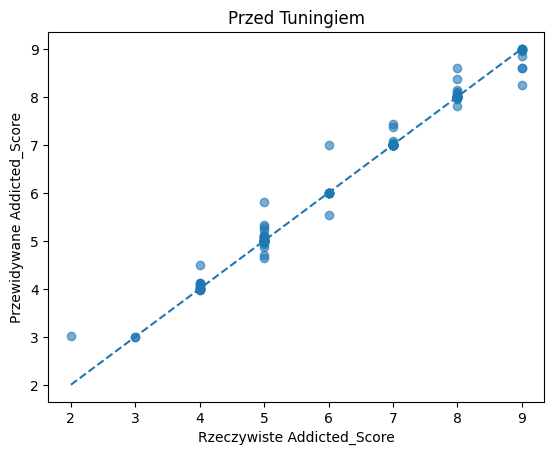

Fitting 5 folds for each of 432 candidates, totalling 2160 fits

=== Po tuningowaniu (GridSearch) ===
Najlepsze parametry:         {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Najlepszy negatywny RMSE (CV): -0.184691800372709
Testowe R2:   0.9858790971496342
Testowe RMSE: 0.18797493042447203


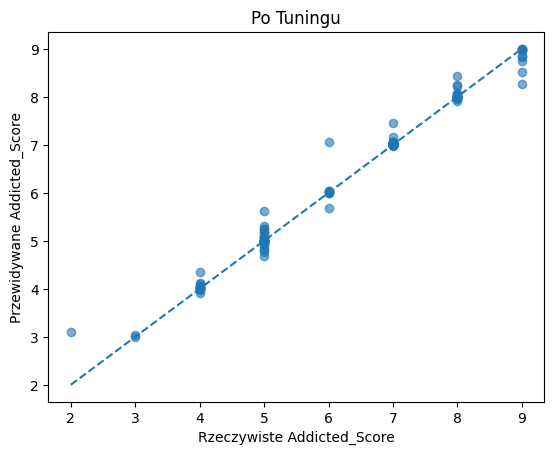

In [29]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
import matplotlib.pyplot as plt

# Podział
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Domyślny RandomForest przed Tuningiem
rf_default = RandomForestRegressor(random_state=42)
rf_default.fit(X_train, y_train)
y_pred_default = rf_default.predict(X_test)
print("=== Baseline (domyślny RF) ===")
print("Baseline R2:   ", rf_default.score(X_test, y_test))
print("Baseline RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_default)))

# y_test, y_pred_default
plt.figure()
plt.scatter(y_test, y_pred_default, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle="--")
plt.xlabel("Rzeczywiste Addicted_Score")
plt.ylabel("Przewidywane Addicted_Score")
plt.title("Przed Tuningiem")
plt.show()

# 3. Przygotowanie przestrzeni hiperparametrów
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5, None]
}

# 4. dla RMSE (negatywny, bo GridSearchCV maksymalizuje)
rmse_scorer = make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=True)

# 5. GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring={"R2": "r2", "RMSE": rmse_scorer},
    refit="RMSE",
    cv=5,
    n_jobs=-1,
    verbose=2,
    error_score="raise"
)

# Tuning
grid_search.fit(X_train, y_train)

# Ewaluacja na teście
print("\n=== Po tuningowaniu (GridSearch) ===")
print("Najlepsze parametry:        ", grid_search.best_params_)
print("Najlepszy negatywny RMSE (CV):", grid_search.best_score_)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Testowe R2:  ", best_rf.score(X_test, y_test))
print("Testowe RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# y_test, y_pred już obliczone po tuningu
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle="--")
plt.xlabel("Rzeczywiste Addicted_Score")
plt.ylabel("Przewidywane Addicted_Score")
plt.title("Po Tuningu")
plt.show()

